In [33]:
# Comprovem que torch estigui instal·lat
try:
    import torch
except:
    print('''No s\'ha detectat torch instal·lat.
Abans de continuar, instal·la'l. 

Windows / MAC:
    pip3 install torch
Linux:
    pip3 install torch==1.9.1+cpu
''')
    raise Exception()

In [34]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from torch_utils import grad

# Introducció a PyTorch

A la segona part de la pràctica farem servir la llibreria PyTorch (torch) per calcular gradients automàticament, sense haver de calcular la fòrmula cada vegada.

PyTorch és molt similar a numpy. En comptes d'arrays, aquí parlem de *tensors*. 

Començarem creant tensors:

In [35]:
torch.ones(10) # ple de 1

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [36]:
torch.zeros(5) # ple de 0

tensor([0., 0., 0., 0., 0.])

In [37]:
torch.full((5, 2), 7) # ple de 7, amb shape (5, 2)

tensor([[7, 7],
        [7, 7],
        [7, 7],
        [7, 7],
        [7, 7]])

In [38]:
torch.Tensor([5, 4, 6]) # creem un tensor a partir d'una llista

tensor([5., 4., 6.])

In [39]:
torch.Tensor(np.array([5, 4, 6])) # a partir d'un np.array

tensor([5., 4., 6.])

Per transformar a numpy, fem servir `.numpy()`

**Compte!** A vegades, quan un tensor ve com a resultat d'una sèrie d'operacions on hi participa un tensor amb requires_grad_(), per transformar a numpy necessitem fer `.detach()` primer: `.detach().numpy()`. Per tant, si surt un missatge d'error dient que necessiteu fer .detach(), feu-ho.

In [40]:
x = np.arange(5)

x

array([0, 1, 2, 3, 4])

In [41]:
xt = torch.Tensor(x) # noteu que per defecte transforma a tipus float, però es pot especificar

xt

tensor([0., 1., 2., 3., 4.])

In [42]:
x2 = xt.numpy()

x2

array([0., 1., 2., 3., 4.], dtype=float32)

Moltes operacions a PyTorch funcionen igual que a numpy (x np.array, xt torch.Tensor):

```
x.sum() -> xt.sum()
x.mean() -> xt.mean()
```

**Compte!** On a numpy passem un paràmetre axis, aquí passem dim.

```
x.sum(axis=1) -> xt.sum(dim=1) # sumem cada fila
```

Algunes funcions es diuen diferent, però són molt similars:

```
x.copy() -> xt.clone()
x.reshape((5, 2)) -> xt.view(5, 2) # noteu, sense haver de passar una tupla
np.concatenate(...) -> torch.cat(...) # concatenar arrays/tensors
```

Per canviar el tipus d'un tensor, cridem a les funcions de cada tipus:

```
x.astype(int) -> xt.int()
x.astype(float) -> xt.float()
x.astype(bool) -> xt.bool()
```

# Càlcul de gradients a PyTorch

Al notebook anterior, donada una funció havíem de definir també la funció que retorna el seu gradient.

En aquesta pràctica, però, veurem que mitjançant l'ús de la llibreria **torch** això no és necessari.

Considerem les següents funcions:

In [43]:
def f1(x):
    return x**2

def f2(x, y):
    return x**2 + y**2

def f3(x, y, z):
    return (100 * (y - x**2)**2 + (1 - x)**2) + (100 * (z - y**2)**2 + (1 - y)**2)

Donada la funció `f1`, podem fàcilment derivar el seu gradient, que és $2x$.

Definim-lo manualment:

In [44]:
def grad_f1_manual(x):
    return 2 * x

In [45]:
# Ara generarem un valor aleatori de x i calcularem el seu gradient amb la funció
x = np.random.normal(size=3)
g = grad_f1_manual(x)

g

array([-0.56934544,  0.24204211, -3.63550905])

Per aquest primer exemple, utilitzarem la següent funció per calcular automàticament el valor del gradient amb PyTorch. No entrarem en detalls de com funciona internament aquesta funció, simplement sapigueu que PyTorch és capaç de retornar-vos el gradient.

In [46]:
# Fem-ho ara amb PyTorch automàticament
xt = torch.Tensor(x)

grad(f1, xt)

(tensor([-0.5693,  0.2420, -3.6355]),)

Fixeu-vos, no hem hagut de calcular cap derivada, PyTorch ja s'encarrega.

De fet, les funcions que li passem poden ser tant complexes com volguem. La única limitació és que:

* Utilitzem tensors de PyTorch.
* Utilitzem només operacions de PyTorch (en comptes de np.sum, fem torch.sum)

In [47]:
# Fem-ho amb f2
grad(f2, torch.randn(4), torch.randn(4))

(tensor([ 1.2744, -4.0789,  0.1253,  0.7843]),
 tensor([ 2.4685, -1.3498,  0.0179,  0.5814]))

In [48]:
# f3
grad(f3, torch.randn(4), torch.randn(4), torch.randn(4))

(tensor([ -384.1472,    65.9419,    28.6735, -1489.4406]),
 tensor([-3387.9302,   -39.8128,  -147.0976, -1861.4662]),
 tensor([-725.3304,   80.1323,  251.4160, -564.9419]))

In [49]:
# Anem a crear una funció deliberadament molt complicada.
def f(x):
    # f(x) = log(|2 * e^x - 5|) si x > 0, x ** 2 - 1 sinó.
    y = torch.zeros(x.shape[0])
    
    y[x > 0] = torch.log(torch.abs(2 * torch.exp(x[x > 0]) - 5))
    y[x <= 0] = x[x <= 0] ** 2 - 1
    
    return y

grad(f, torch.randn(3))

(tensor([13.0165, -0.6166, -2.7969]),)

# Optimització amb PyTorch

Veieu que podem calcular gradients amb PyTorch de forma automàtica. És més, podem utilitzar diferents algorismes d'optimització directament de torch, no cal que implementem cap d'ells.

Anem a calcular el mínim de les funcions f3 i f4 de la part anterior. Farem servir la funció "train_parameters" que trobareu al mòdul training.py a aquesta mateixa carpeta.

In [50]:
from torch import optim # al subpaquet optim tenim tots els optimitzadors
from torch_utils import minimize

In [51]:
def f3(x, y):
    return x**2 + y**2

def f4(x, y):
    return 100 * (x**2 + y**2)

Cridem a la funció train_parameters, passant-li la funció
"objectiu" que volem minimitzar (loss), els inputs a optimitzar,
l'optimizer (el mètode d'optimització) a utilitzar 
i el pas del gradient (lr).

(tensor([2.1271e-10]), tensor([-3.6429e-09]), tensor([1.3316e-17]))

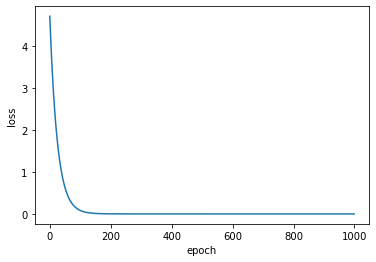

In [52]:
x, y = torch.randn(1), torch.randn(1)

# Utilitzarem l'optimizer SGD = Stochastic Gradient Descent
x, y = minimize(f3, x, y, optimizer=optim.SGD, lr=1e-2)

x, y, f3(x, y)

Recordeu que si el pas (lr) és de 1e-2, f4 es quedarà atascada amb un Gradient Descent pur.

(tensor([0.8145]), tensor([-1.1426]), tensor([196.8961]))

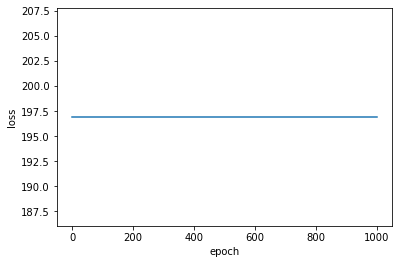

In [57]:
x, y = torch.randn(1), torch.randn(1)

# Utilitzarem l'optimizer SGD = Stochastic Gradient Descent
x, y = minimize(f4, x, y, optimizer=optim.SGD, lr=1e-2)

x, y, f4(x, y)

Amb PyTorch podem utilitzar altres optimizers de torch.optim que esquiven aquest tipus de problemes. Un dels més utilitzats és Adam:

(tensor([1.3125e-24]), tensor([-1.9707e-24]), tensor([0.]))

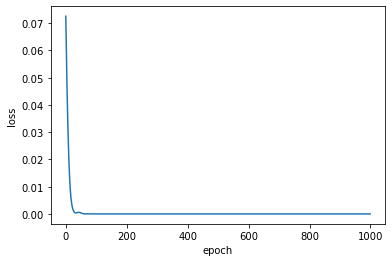

In [54]:
x, y = torch.randn(1), torch.randn(1)

x, y = minimize(f3, x, y, optimizer=optim.Adam, lr=1e-2)
x, y, f3(x, y)

(tensor([-7.3192e-25]), tensor([-4.3527e-21]), tensor([1.8946e-39]))

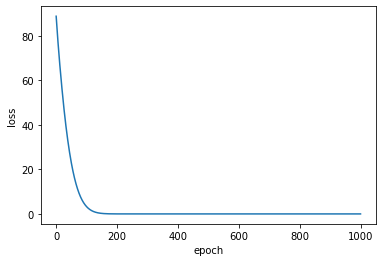

In [55]:
x, y = torch.randn(1), torch.randn(1)

x, y = minimize(f4, x, y, optimizer=optim.Adam, lr=1e-2)
x, y, f4(x, y)

En definitiva, podem utilitzar PyTorch tant per calcular els gradients automàticament com per fer les optimitzacions que volguem. En un cas real, no cal que implementeu vosaltres mateixos l'algorisme optimitzador, el càlcul del gradient, ni res similar.

Al següent notebook farem servir PyTorch per entrenar un model predictor.